In [1]:
import numpy as np
import pandas as pd

import os
print(os.listdir("../input"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
%%time

train = pd.read_csv("../input/train.csv")
test= pd.read_csv("../input/test.csv")

CPU times: user 5.99 s, sys: 625 ms, total: 6.62 s
Wall time: 6.63 s


In [3]:
print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)

In [7]:
X_train = X_train / 255.0
test = test / 255.0

In [8]:
print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [9]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [10]:
print(train.shape, test.shape)

(42000, 785) (28000, 28, 28, 1)


把 y 独热编码。

In [11]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)

Using TensorFlow backend.


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=2)
print("X_train shape", X_train.shape)
print("X_test shape", X_val.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_val.shape)

X_train shape (37800, 28, 28, 1)
X_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model = Sequential()
#
model.add(
    Conv2D(
        filters=8,
        kernel_size=(5, 5),
        padding='Same',
        activation='relu',
        input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
#
model.add(
    Conv2D(filters=16, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(rate=0.25))

# fully connected
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(10, activation="softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
__________

In [15]:
from keras.optimizers import Adam, RMSprop

optimizer = Adam()

# Compile the model
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
epochs = 10  
batch_size = 250

In [17]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # dimesion reduction
    rotation_range=0.5,  # randomly rotate images in the range 5 degrees
    zoom_range=0.5,  # Randomly zoom image 5%
    width_shift_range=0.5,  # randomly shift images horizontally 5%
    height_shift_range=0.5,  # randomly shift images vertically 5%
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [18]:
%%time
history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    steps_per_epoch=X_train.shape[0] // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
151/151 [==============================] - 14s 94ms/step - loss: 2.2164 - acc: 0.1787 - val_loss: 1.7553 - val_acc: 0.3769
Epoch 2/10
151/151 [==============================] - 15s 100ms/step - loss: 1.9159 - acc: 0.3146 - val_loss: 1.2138 - val_acc: 0.6579
Epoch 3/10
151/151 [==============================] - 14s 94ms/step - loss: 1.7257 - acc: 0.3883 - val_loss: 0.9198 - val_acc: 0.7255
Epoch 4/10
151/151 [==============================] - 13s 89ms/step - loss: 1.6248 - acc: 0.4319 - val_loss: 0.7175 - val_acc: 0.8238
Epoch 5/10
151/151 [==============================] - 14s 92ms/step - loss: 1.5466 - acc: 0.4648 - val_loss: 0.5768 - val_acc: 0.8664
Epoch 6/10
151/151 [==============================] - 14s 95ms/step - loss: 1.4875 - acc: 0.4860 - val_loss: 0.5174 - val_acc: 0.8883
Epoch 7/10
151/151 [==============================] - 15s 97ms/step - loss: 1.4498 - acc: 0.5026 - val_loss: 0.4090 - val_acc: 0.9060
Epoch 8/10
15

In [19]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

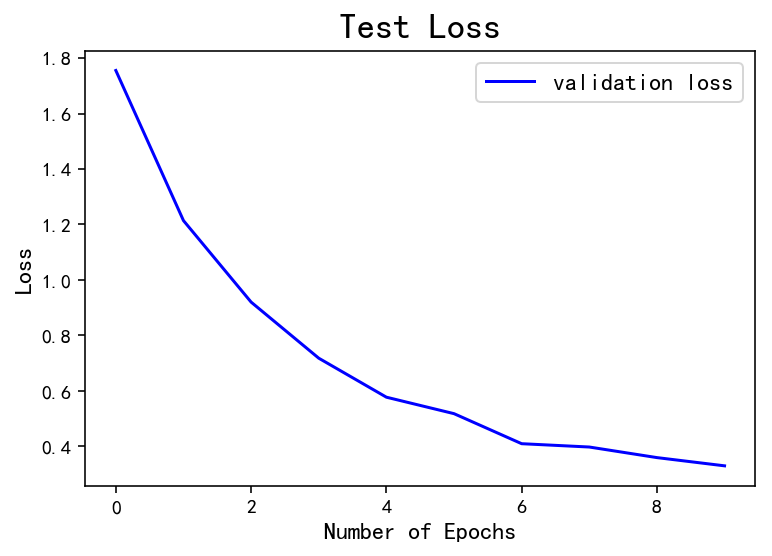

In [20]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss", fontsize=18)
plt.xlabel("Number of Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [21]:
y_pred_proba = model.predict(X_val, verbose=1)
y_pred_proba

4200/4200 [==============================] - 1s 140us/step


array([[7.7151167e-03, 3.7243746e-07, 1.2616893e-04, ..., 6.6089501e-10,
        6.2241834e-03, 7.3516344e-06],
       [7.4047265e-03, 7.1741937e-04, 1.7271277e-02, ..., 3.4363545e-02,
        7.9298101e-02, 8.2181859e-01],
       [1.3895279e-03, 1.1137933e-05, 3.4132707e-03, ..., 1.4788612e-05,
        4.6309482e-02, 3.6022178e-04],
       ...,
       [2.0511507e-04, 2.1915902e-07, 8.7966615e-01, ..., 1.8094584e-03,
        1.2633122e-03, 2.3779631e-04],
       [3.8773011e-02, 8.3537328e-05, 3.9681882e-01, ..., 7.3131378e-04,
        1.2817447e-01, 2.9735125e-03],
       [4.8715129e-01, 1.5955170e-04, 2.1472587e-03, ..., 7.0159508e-06,
        6.2370811e-02, 4.8309569e-03]], dtype=float32)

In [22]:
y_pred_classes = model.predict_classes(X_val)
y_pred_classes

array([6, 9, 5, ..., 2, 2, 0])

In [23]:
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_val, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
confusion_mtx

array([[384,   0,   1,   0,   0,   0,   6,   0,  20,   0],
       [  0, 462,   9,   1,   1,   0,   7,   0,   5,   0],
       [  6,   0, 365,  14,   2,   2,   5,   1,   8,   0],
       [  0,   0,   5, 389,   0,  10,   0,   3,   7,   4],
       [  2,   0,   2,   0, 426,   0,  15,   1,   1,  14],
       [  8,   0,   7,  16,   0, 316,   6,   0,  14,   5],
       [ 13,   1,   1,   0,   1,   0, 391,   0,   6,   0],
       [  1,   0,   3,  12,   0,   0,   0, 417,   1,  12],
       [  5,   1,   1,   2,   2,   3,   6,   0, 358,   4],
       [ 16,   2,   0,   6,   8,   3,   0,  17,  10, 347]])

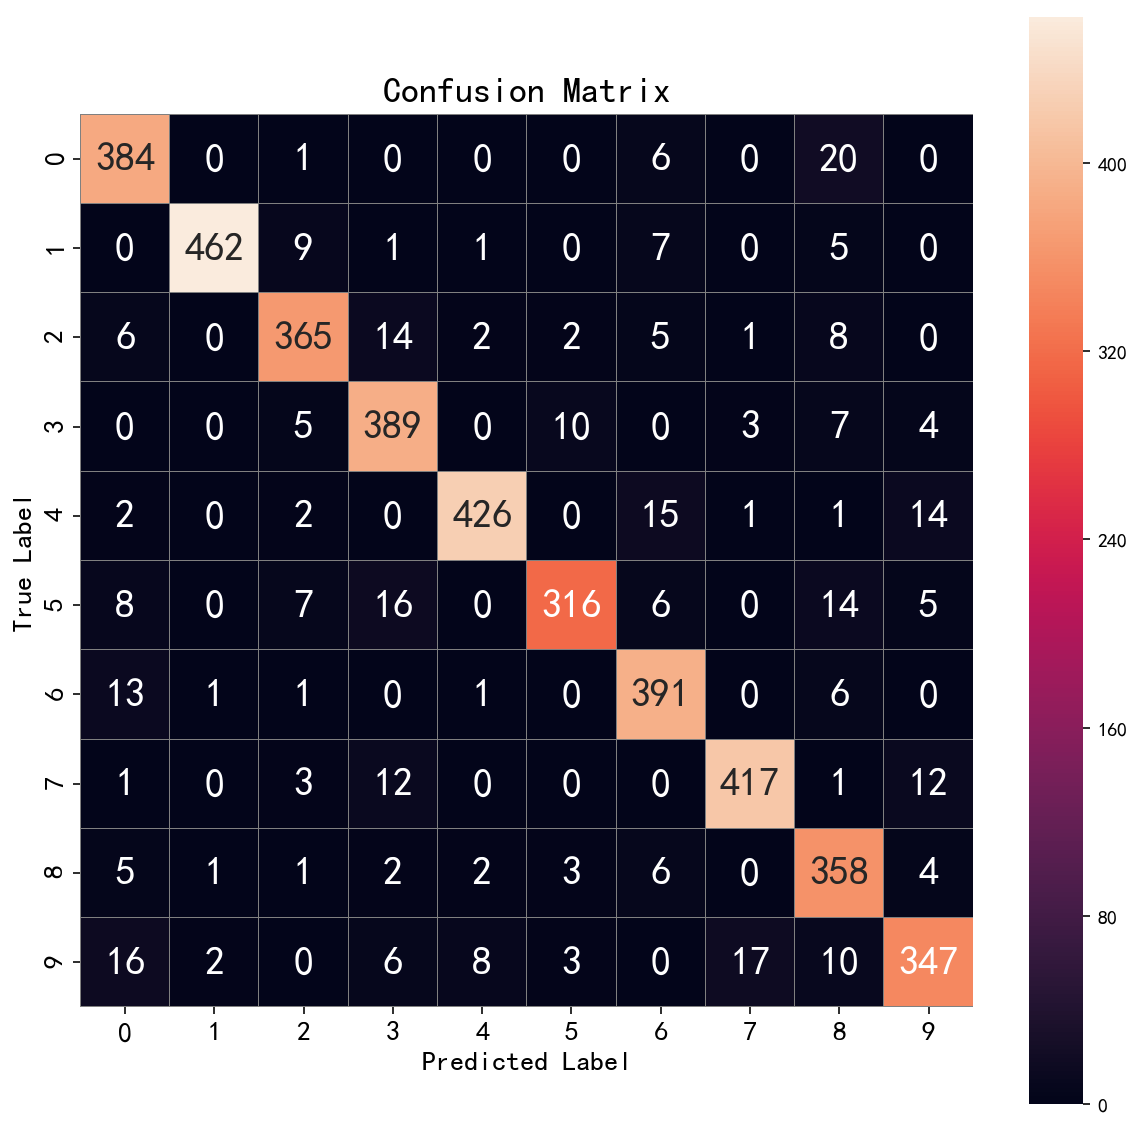

In [25]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    confusion_mtx,
    annot=True,
    linewidths=0.01,
    # cmap="Greens",
    linecolor="gray",
    fmt='d',  # fmt='.1f',
    annot_kws={'fontsize': 20},
    square=True,
    ax=ax)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [26]:
y_pred = model.predict_classes(test, verbose=1)

28000/28000 [==============================] - 4s 131us/step


In [27]:
submission = pd.DataFrame({'ImageId': range(1, 28001), 'Label': y_pred})
submission.to_csv('../output/keras-cnn-data-augmentation-submission.csv', index=None)

# 0.92314